# System identification of Lindblad master equation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, inv, norm
from qutip import rand_herm, rand_dm, mesolve, Qobj, fidelity

from ncpol2sdpa import generate_variables, SdpRelaxation
from sympy import Matrix, I, eye, re, im, diag, solve, lambdify

from scipy.optimize import minimize

# utilities

In [2]:
def unknown_complex_matrix(name, n):
    return Matrix(n, n, generate_variables('Re' + name, n * n)) \
        + I * Matrix(n, n, generate_variables('Im' + name, n * n))

In [3]:
def unknown_complex_tracless_matrix(name, n):
    result = Matrix(n, n, generate_variables('Re' + name, n * n - 1) + [0,])
    result += I * Matrix(n, n, generate_variables('Im' + name, n * n - 1) + [0,])
    
    result[-1, -1] = -result.trace()
    return result

In [4]:
def unknown_real_matrix(name, n):
    return Matrix(n, n, generate_variables(name, n * n))

In [5]:
def unknown_hermitian_matrix(name, n):
    
    x = generate_variables(name, n ** 2)
    M = diag(*x[:n])
    M /= 2
    x = x[n:]

    for i in range(n - 1):
        for j in range(i + 1, n):
            M[i, j] = x.pop() + I * x.pop()
            
    M += M.H
    
    return M

# Generate data

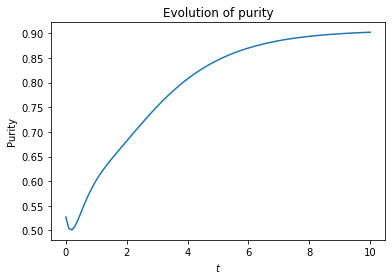

In [6]:
H_exact = rand_herm(2)
                    
A_exact = np.random.rand(2, 2) + 1j * np.random.rand(2, 2)
#A_exact[-1, -1] = 0
#A_exact[-1, -1] = -A_exact.trace()

results = mesolve(H_exact, rand_dm(2), np.linspace(0, 10, 100), [Qobj(A_exact)])
# Comvert states to numpy array
rho = [_.data.toarray() for _ in results.states]

plt.title("Evolution of purity")
plt.plot(results.times, [_.purity() for _ in results.states])
plt.xlabel('$t$')
plt.ylabel('Purity')
plt.show()

In [7]:
H_exact * A_exact - A_exact * H_exact

array([[ 0.        +0.j        ,  0.36292987+0.05537801j],
       [-0.34080413-0.06397304j,  0.        +0.j        ]])

# Define objective function

In [8]:
H = unknown_hermitian_matrix('H', 2)
A = unknown_complex_matrix('A', H.shape[0])

def rhs(rho):
    """
    Right hand side of the Lindblad master equation
    """
    return -I * (H @ rho - rho @ H) \
        + A @ rho @ A.H - (A.H @ A @ rho + rho @ A.H @ A) / 2

In [9]:
# the density matrix integrated over time
int_rho = np.trapz(
    rho,
    x=results.times,
    axis=0
)

In [10]:
obj = (rho[-1] - rho[0] - rhs(int_rho)).norm() ** 2
obj = re(obj.simplify())

## Check that the exact solution zeros the objective function

In [11]:
exact_solution = solve(H - H_exact) 
exact_solution.update(solve(A - A_exact))

obj.subs(exact_solution)

4.53860619131774e-6

In [12]:
"""
level = 2

sdp = SdpRelaxation(list(obj.free_symbols))
sdp.get_relaxation(level, objective=obj)
sdp.solve(solver='mosek')

# extract the values of control
if sdp.status == 'optimal':
    solution = {var: sdp[var] for var in sdp.variables}
else:
    solution = None

obj.subs(solution)
"""

"\nlevel = 2\n\nsdp = SdpRelaxation(list(obj.free_symbols))\nsdp.get_relaxation(level, objective=obj)\nsdp.solve(solver='mosek')\n\n# extract the values of control\nif sdp.status == 'optimal':\n    solution = {var: sdp[var] for var in sdp.variables}\nelse:\n    solution = None\n\nobj.subs(solution)\n"

In [13]:
#H.subs(solution)

## using Scipy for minimization

In [14]:
# get the objective function
f = re(obj)

# list of unknowns
x = list(obj.free_symbols)

# symbolically get the Jacobian
jac = [f.diff(_) for _ in x]

f = lambdify(x, f, 'numpy')
jac = lambdify(x, jac, 'numpy')

# Use the conjugate gradient method in scipy since we have both the Jacobian and Hessian of the objective function
scipy_solution = minimize(
    lambda _: f(*_),
    np.ones(len(x)),
    jac=lambda _: jac(*_),
)

if scipy_solution.success:
    solution = dict(zip(x, scipy_solution.x))
    
    H_reconstructed = np.array(H.subs(solution), dtype=np.complex)
    A_reconstructed = np.array(A.subs(solution), dtype=np.complex)
    
else:
    solution = H_reconstructed = A_reconstructed = None

In [15]:
A_reconstructed, A_exact

(array([[1.05959755+0.49069581j, 0.76323277+1.30699608j],
        [0.72523977+0.32330397j, 0.93232269+1.42562195j]]),
 array([[0.29108624+0.20817412j, 0.90034625+0.13738021j],
        [0.84545735+0.15870254j, 0.96406715+0.96810648j]]))

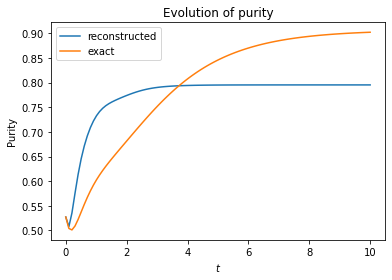

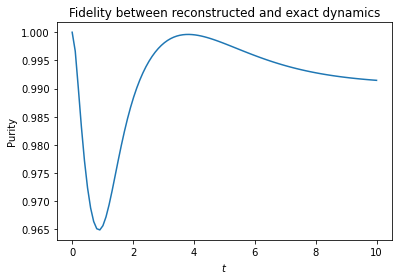

In [16]:
results_reconstructed = mesolve(
    Qobj(H_reconstructed), Qobj(rho[0]), results.times, [Qobj(A_reconstructed)]
)

plt.title("Evolution of purity")
plt.plot(
    results.times, 
    [_.purity() for _ in results_reconstructed.states],
    label='reconstructed'
)
plt.plot(
    results.times, 
    [_.purity() for _ in results.states],
    label='exact'
)

plt.xlabel('$t$')
plt.ylabel('Purity')
plt.legend()
plt.show()

plt.title("Fidelity between reconstructed and exact dynamics")
plt.plot(
    results.times, 
    [fidelity(rho1, rho2) for rho1, rho2 in zip(results_reconstructed.states, results.states)]
)

plt.xlabel('$t$')
plt.ylabel('Purity')
plt.show()

# Second cost function

In [ ]:
obj = 0

for t in range(2, len(rho) + 1):
    # the density matrix integrated over time
    int_rho = np.trapz(
        rho[:t],
        x=results.times[:t],
        axis=0
    )
    
    obj += (rho[t - 1] - rho[0] - rhs(int_rho)).norm() ** 2

obj = re(obj.simplify())

## Check that the exact solution zeros the objective function

In [ ]:
obj.subs(exact_solution)

In [ ]:
"""
level = 2

sdp = SdpRelaxation(list(obj.free_symbols))
sdp.get_relaxation(level, objective=obj)
sdp.solve(solver='mosek')

# extract the values of control
if sdp.status == 'optimal':
    solution = {var: sdp[var] for var in sdp.variables}
else:
    solution = None

obj.subs(solution)
"""

In [ ]:
#H.subs(solution)

# using Scipy for minimization

In [ ]:
# get the objective function
f = re(obj)

# list of unknowns
x = list(obj.free_symbols)

# symbolically get the Jacobian
jac = [f.diff(_) for _ in x]

f = lambdify(x, f, 'numpy')
jac = lambdify(x, jac, 'numpy')

# Use the conjugate gradient method in scipy since we have both the Jacobian and Hessian of the objective function
scipy_solution = minimize(
    lambda _: f(*_),
    np.ones(len(x)),
    jac=lambda _: jac(*_),
)

if scipy_solution.success:
    solution = dict(zip(x, scipy_solution.x))
    
    H_reconstructed = np.array(H.subs(solution), dtype=np.complex)
    A_reconstructed = np.array(A.subs(solution), dtype=np.complex)
    
else:
    solution = H_reconstructed = A_reconstructed = None

In [ ]:
A_reconstructed, A_exact

In [ ]:
results_reconstructed = mesolve(
    Qobj(H_reconstructed), Qobj(rho[0]), results.times, [Qobj(A_reconstructed)]
)

plt.title("Evolution of purity")
plt.plot(
    results.times, 
    [_.purity() for _ in results_reconstructed.states],
    label='reconstructed'
)
plt.plot(
    results.times, 
    [_.purity() for _ in results.states],
    label='exact'
)

plt.xlabel('$t$')
plt.ylabel('Purity')
plt.legend()
plt.show()

plt.title("Fidelity between reconstructed and exact dynamics")
plt.plot(
    results.times, 
    [fidelity(rho1, rho2) for rho1, rho2 in zip(results_reconstructed.states, results.states)]
)

plt.xlabel('$t$')
plt.ylabel('Purity')
plt.show()

# Objective function inspired by implicit Euler method

In [ ]:
dt = results.times[1] - results.times[0]

obj = 0

for t in range(1, len(rho)):
    
    obj += (rho[t] - rho[t - 1] - dt * rhs(rho[t])).norm() ** 2

obj = re(obj.simplify())

## Check that the exact solution zeros the objective function

In [ ]:
obj.subs(exact_solution)

In [ ]:
"""
level = 4

sdp = SdpRelaxation(list(obj.free_symbols))
sdp.get_relaxation(level, objective=obj)
sdp.solve(solver='mosek')

# extract the values of control
if sdp.status == 'optimal':
    solution = {var: sdp[var] for var in sdp.variables}
else:
    solution = None
    
obj.subs(solution)
"""

## using Scipy for minimization

In [ ]:
# get the objective function
f = re(obj)

# list of unknowns
x = list(obj.free_symbols)

# symbolically get the Jacobian
jac = [f.diff(_) for _ in x]

f = lambdify(x, f, 'numpy')
jac = lambdify(x, jac, 'numpy')

# Use the conjugate gradient method in scipy since we have both the Jacobian and Hessian of the objective function
scipy_solution = minimize(
    lambda _: f(*_),
    0.01 * np.random.rand(len(x)),
    jac=lambda _: jac(*_),
)

if scipy_solution.success:
    solution = dict(zip(x, scipy_solution.x))
    
    H_reconstructed = np.array(H.subs(solution), dtype=np.complex)
    A_reconstructed = np.array(A.subs(solution), dtype=np.complex)
    
else:
    solution = H_reconstructed = A_reconstructed = None

In [ ]:
A_reconstructed, A_exact

In [ ]:
results_reconstructed = mesolve(
    Qobj(H_reconstructed), Qobj(rho[0]), results.times, [Qobj(A_reconstructed)]
)

plt.title("Evolution of purity")
plt.plot(
    results.times, 
    [_.purity() for _ in results_reconstructed.states],
    label='reconstructed'
)
plt.plot(
    results.times, 
    [_.purity() for _ in results.states],
    label='exact'
)

plt.xlabel('$t$')
plt.ylabel('Purity')
plt.legend()
plt.show()

plt.title("Fidelity between reconstructed and exact dynamics")
plt.plot(
    results.times, 
    [fidelity(rho1, rho2) for rho1, rho2 in zip(results_reconstructed.states, results.states)]
)

plt.xlabel('$t$')
plt.ylabel('Purity')
plt.show()